In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pipeline import process_dataset, match_frags_and_mols, compile_results_into_df
from utils import draw_mols_with_highlight

/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jackie16201/Desktop/Spring_2023/fragments_discovery_design_ML/src/pipeline.py:11: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS


# Part 1: Process SA scores (mini version of fragment algorithm)

In [8]:
# Values for processing fragments and compounds
fragment_path = '../out/model_preds_on_frags_and_cpds/SA/FINISHED_combined_fragment_preds_05_24_2022.csv'
compound_path = '../out/model_preds_on_frags_and_cpds/SA/combined_broad_preds_05_20_2022.csv'
result_path = '../out/controls/exploratory_scatterplot_SA_'
fragment_smi_col = 'SMILES'
compound_smi_col = 'smiles'
fragment_hit_col = 'ACTIVITY'
compound_hit_col = 'ACTIVITY'

# filters and thresholds for fragments and compounds
fragment_score = 0.05
compound_score = 0.05
fragment_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
compound_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
fragment_require_more_than_coh = False

def mini_algo(fragment_path, compound_path, result_path, fragment_smi_col = 'smiles', compound_smi_col = 'smiles', fragment_hit_col = 'hit', compound_hit_col = 'hit', fragment_score = 0.2, compound_score = 0.2, fragment_require_more_than_coh = True, fragment_remove_pains_brenk = 'both', compound_remove_pains_brenk = 'both', fragment_druglikeness_filter=[], compound_druglikeness_filter =[], fragment_remove_patterns=[]):
    ##### part 1: process frags and compounds #####
    print('\nProcessing fragments...')
    df, mols, _ = process_dataset(frag_or_cpd='frag', path=fragment_path, score=fragment_score, smi_col=fragment_smi_col, hit_col=fragment_hit_col, require_more_than_coh=fragment_require_more_than_coh, remove_pains_brenk=fragment_remove_pains_brenk, druglikeness_filter=fragment_druglikeness_filter, remove_patterns=fragment_remove_patterns)
    print('\nProcessing compounds...')
    cpd_df, cpd_mols, full_cpd_df = process_dataset(frag_or_cpd='cpd', path=compound_path, score=compound_score, smi_col=compound_smi_col, hit_col=compound_hit_col, require_more_than_coh=False, remove_pains_brenk=compound_remove_pains_brenk, druglikeness_filter=compound_druglikeness_filter, remove_patterns=[])
    print('\nMatching fragments in compounds...')
        
    ##### part 2: get all matching frag / molecule pairs #####
    frag_match_indices, cpd_match_indices_lists = match_frags_and_mols(mols, cpd_mols)
    rank_df = compile_results_into_df(df, cpd_df, mols, frag_match_indices, cpd_match_indices_lists, result_path)
    return(rank_df)

In [9]:
rank_df = mini_algo(fragment_path=fragment_path,
                    compound_path=compound_path,
                    result_path=result_path,
                    fragment_smi_col=fragment_smi_col,
                    compound_smi_col=compound_smi_col,
                    fragment_hit_col=fragment_hit_col,
                    compound_hit_col=compound_hit_col,
                    fragment_score=fragment_score,
                    compound_score=compound_score,
                    fragment_remove_pains_brenk=fragment_remove_pains_brenk,
                    compound_remove_pains_brenk=compound_remove_pains_brenk, 
                    fragment_require_more_than_coh=fragment_require_more_than_coh)



Processing fragments...
length of df:  27523571
length of df >0.05:  238434
length of df with valid mols:  238434
length of all preds with clean (no PAINS or Brenk) mols:  81864

Processing compounds...
length of df:  799147
length of df >0.05:  145076
length of df with valid mols:  145076


In [2]:
old

length of df >0.05:  145076


100%|████████████████████████████| 145076/145076 [00:18<00:00, 7694.69it/s]


length of df with valid mols:  145076


100%|█████████████████████████████| 145076/145076 [05:00<00:00, 482.56it/s]


length of all preds with clean (no PAINS or Brenk) mols:  86723


In [4]:
# get all matching frag / molecule pairs
frag_match_indices, cpd_match_indices_lists = match_frags_and_mols(mols, cpd_mols)

# make df
rank_df = pd.DataFrame()
rank_df['matched_fragments'] = frag_match_indices
rank_df['fragment_SMILES'] = [mols[i].GetProp('SMILES') for i in list(rank_df['matched_fragments'])]
rank_df['matched_molecules'] = cpd_match_indices_lists
rank_df['fragment_scores'] = [df.iloc[i,list(df.columns).index('ACTIVITY')] for i in frag_match_indices]
rank_df['full_molecule_scores'] = [[cpd_df.iloc[i,list(cpd_df.columns).index('ACTIVITY')] for i in sublist] for sublist in cpd_match_indices_lists]
rank_df.to_csv('../figs/intermediate_data/rank_df_fragments_molecules_scores_scatter.csv')


81864it [8:24:39,  2.70it/s] 


number of matched fragments:  333


OSError: Cannot save file into a non-existent directory: '../out/figs/intermediate_data'

# Part 2: Plot SA scores with hardcoded examples

In [7]:
# get all frag and mol scores
frag_scos = []
mol_scos = []

for i,row in rank_df.iterrows():
    frag_sco = float(row['fragment_scores'])
    full_mol_scos = list(row['full_molecule_scores'])
    frag_scos.extend([frag_sco] * len(full_mol_scos))
    mol_scos.extend(full_mol_scos)

In [96]:
# hardcoded examples of a successful and unsuccessful compound with scores
success_mol = Chem.MolFromSmiles('COc1ccc2[nH]cc(c2c1)CCNC(=O)Nc1ccc(c(c1)Cl)Cl') # BRD-K39227016
successs_mol_score = 0.2386302828788757 

fail_mol = Chem.MolFromSmiles('CCCC1=CC(=O)N=C(N1)SCC(=O)Nc1ccc(c(c1)Cl)Cl') # BRD-K23971431
fail_mol_score = 0.1560791455209255

path = '../figs/intermediate_data/scatterplot_'
frag = 'CNC1=CC=C(Cl)C(Cl)=C1'
draw_mols_with_highlight([success_mol], frag, legends=['BRD-K39227016: 0.239'], file_path=path + 'success_example.png')
draw_mols_with_highlight([fail_mol], frag, legends=['BRD-K23971431: 0.156'], file_path=path + 'fail_example.png')

# add the success/fail mols as examples
EX_frag_scos = [0.1714286329806782] * 2 # fragment score
EX_mol_scos = [successs_mol_score, fail_mol_score]

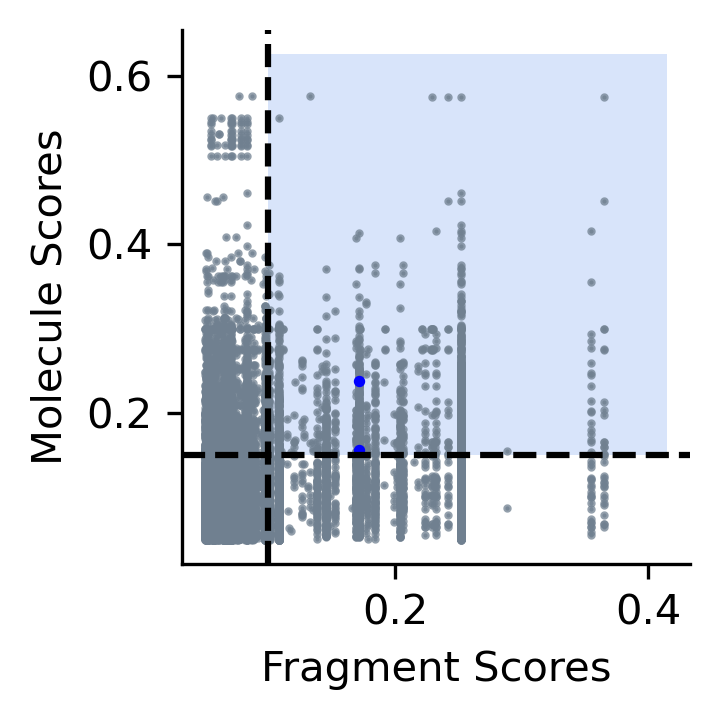

In [115]:
fig, ax = plt.subplots(figsize = (2.5,2.5), dpi = 300)
rect = patches.Rectangle((0.1, 0.15), max(frag_scos)-0.1+0.05,max(mol_scos)-0.15+0.05, alpha = 0.25, linewidth=1, facecolor='cornflowerblue')
plt.axvline(0.1, color = 'black', linestyle = '--')
plt.axhline(0.15, color = 'black', linestyle = '--')
ax.add_patch(rect)

plt.scatter(frag_scos, mol_scos, alpha = 0.75, s=1, color = 'slategrey') # , label = 'Inhibition Prediction'
plt.scatter(EX_frag_scos, EX_mol_scos, alpha = 1, s=3, color = 'blue') # , label = 'Inhibition Prediction'

plt.xlabel('Fragment Scores')
plt.ylabel('Molecule Scores')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figs/figure_panels/frag_vs_cpd_scores.png')
plt.savefig('../figs/figure_panels/frag_vs_cpd_scores.svg')
plt.show()